In [3]:
import numpy as np
import argparse
import os
import torch
import random
import cv2

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import auc
from prettytable import PrettyTable

from iresnet import iresnet18,iresnet34,iresnet50,iresnet100,iresnet200
from resnet import resnet50
from align import Face_Align

import sys

In [4]:
shape_predictor_path = "./face-alignment-dlib/shape_predictor_68_face_landmarks.dat"

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

In [5]:
class VGGFace2_verifacation(object):
    def __init__(self,vggnet):
        self.net = vggnet
        self.net.eval()
        self.hook_feature = None
    def _register_hook(self,net,layer_name):
        for (name, module) in net.named_modules():
            if name == layer_name:
                module.register_forward_hook(self._get_features_hook)
    def _get_features_hook(self,module, input, output):
        self.hook_feature = output.view(output.size(0), -1)[0]
    def __call__(self,input):
        self._register_hook(self.net,"avgpool")
        self.net.zero_grad()
        self.net(input)
        return torch.unsqueeze(self.hook_feature, dim=0)

In [6]:
def read_datasets(real_dir,fake_dir):
    real_dir_lists = os.listdir(real_dir)
    fake_dir_lists = os.listdir(fake_dir)

    images_dir = []
    # real
    for real in real_dir_lists:
        selected = [x for x in fake_dir_lists if x.split("_")[0]==real.split("-")[0]]
        for fake in selected:
            images_dir.append([os.path.join(real_dir,real),os.path.join(fake_dir,fake)])
    return images_dir

def get_net(net_type):
    arcface_r50_path = "./pre-trained/ms1mv3_arcface_r50_fp16/backbone.pth"
    arcface_r100_path = "./pre-trained/ms1mv3_arcface_r100_fp16/backbone.pth"
    cosface_r50_path = "./pre-trained/glint360k_cosface_r50_fp16_0.1/backbone.pth"
    cosface_r100_path = "./pre-trained/glint360k_cosface_r100_fp16_0.1/backbone.pth"
    if net_type == "ArcFace-r50":
        net = iresnet50()
        net.load_state_dict(torch.load(arcface_r50_path))
        if torch.cuda.is_available():
            net.cuda()
        net.eval()    
    elif net_type == "ArcFace-r100":
        net = iresnet100()
        net.load_state_dict(torch.load(arcface_r100_path))
        if torch.cuda.is_available():
            net.cuda()
        net.eval()
    elif net_type == "CosFace-r50":
        net = iresnet50()
        net.load_state_dict(torch.load(cosface_r50_path))
        if torch.cuda.is_available():
            net.cuda()
        net.eval()
    elif net_type == "CosFace-r100":
        net = iresnet100()
        net.load_state_dict(torch.load(cosface_r100_path))
        if torch.cuda.is_available():
            net.cuda()
        net.eval()
    elif net_type == "VGGFace2":
        from resnet import resnet50
        weight_path = "./pre-trained/resnet50_scratch_weight.pkl"
        vggnet = resnet50(num_classes=8631)
        with open(weight_path, 'rb') as f:
            obj = f.read()
            weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
        vggnet.load_state_dict(weights, strict=True)

        if torch.cuda.is_available():
            vggnet.cuda()
        net = VGGFace2_verifacation(vggnet)
    return net

def Image_Preprocessing(net_type,image):
    '''
    Precessing the input images
        image_dir: single image input path, such as "/home/xxx/10.jpg"
    '''
    if net_type in ['ArcFace-r50','ArcFace-r100',"CosFace-r50","CosFace-r100"]:
        image = Image.fromarray(cv2.cvtColor(np.uint8(image),cv2.COLOR_BGR2RGB))
        return transforms(image.resize((112, 112), Image.BILINEAR))
    elif net_type in ["VGGFace2","VGGFace2-verification"]:
        mean_bgr = np.array([91.4953, 103.8827, 131.0912])
        assert image is not None
        image = cv2.resize(image,(224,224))
        image = image.astype(np.float32)
        image -= mean_bgr
        # H * W * C   -->   C * H * W
        image = image.transpose(2,0,1)
        return torch.tensor(image)

def verification(args,images_dir):
    net = get_net(args)

    similarity = []
    label = []

    align = Face_Align(shape_predictor_path)

    for data in tqdm(images_dir):
        path1 = data[0]
        path2 = data[1]
        # image1 = Image.open(path1).resize((112, 112), Image.BILINEAR)
        # image2 = Image.open(path2).resize((112, 112), Image.BILINEAR)
        # image1 = transforms(image1)
        # image2 = transforms(image2)
        try:
            image1,image2 = align.real_fake(cv2.imread(path1),cv2.imread(path2))
        # image1 = align(cv2.imread(path1))
        # image2 = align(cv2.imread(path2))

        
            image1 = Image_Preprocessing(args,image1)
            image2 = Image_Preprocessing(args,image2)

            output1 = F.normalize(net(torch.unsqueeze(image1, dim=0).cuda()),p=2,dim=1)
            output2 = F.normalize(net(torch.unsqueeze(image2, dim=0).cuda()),p=2,dim=1)

            similar = torch.cosine_similarity(output1[0], output2[0], dim=0).item()

            similarity.append(similar)
            label.append(1)
        except:
            pass
    return similarity,label

def AUC(score,label):
    score = np.array(score)
    label = np.array(label)

    x_labels = [10**-6, 10**-5, 10**-4,10**-3, 10**-2, 10**-1,0.2,0.4,0.6,0.8,1]
    tpr_fpr_table = PrettyTable(map(str, x_labels))
    
    fpr, tpr, thresholds = metrics.roc_curve(label, score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    fpr = np.flipud(fpr)
    tpr = np.flipud(tpr) # select largest tpr at same fpr

    tpr_fpr_row = []
    
    for fpr_iter in np.arange(len(x_labels)):
        _, min_index = min(list(zip(abs(fpr-x_labels[fpr_iter]), range(len(fpr)))))
        tpr_fpr_row.append('%.4f' % tpr[min_index])
    tpr_fpr_table.add_row(tpr_fpr_row)

    print(tpr_fpr_table)
    print("ROC AUC: {}".format(roc_auc))

In [7]:
images_dir = read_datasets(real_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_1/real_ima",
                           fake_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_1/fake_ima")
similarity1,label1 = verification("CosFace-r100",images_dir)

100%|██████████| 2500/2500 [03:30<00:00, 11.86it/s]


In [8]:
images_dir = read_datasets(real_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_2/real_ima",
                           fake_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_2/fake_ima")
similarity2,label2 = verification("CosFace-r100",images_dir)

100%|██████████| 5000/5000 [06:42<00:00, 12.42it/s]


In [9]:
images_dir = read_datasets(real_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_3/real_ima",
                           fake_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_3/fake_ima")
similarity3,label3 = verification("CosFace-r100",images_dir)

100%|██████████| 5000/5000 [07:01<00:00, 11.87it/s]


In [10]:
images_dir = read_datasets(real_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_4/real_ima",
                           fake_dir = "/exdata/HLt/StarGAN_all_file/StarGAN_base/stargan_vgg/results_all_4/fake_ima")
similarity4,label4 = verification("CosFace-r100",images_dir)

100%|██████████| 2500/2500 [03:34<00:00, 11.68it/s]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


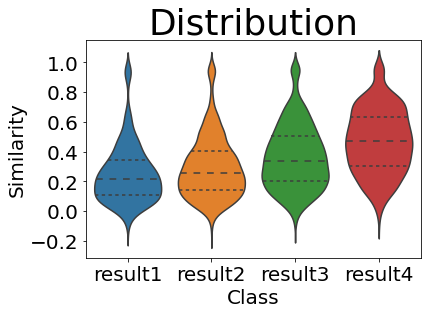

In [18]:
df = pd.DataFrame(np.array([similarity1+similarity2+similarity3+similarity4,label1+list(np.array(label2)+1)+list(np.array(label3)+2)+list(np.array(label4)+3)]).T)

sns.violinplot(x=1, y=0, data=df, scale='width', inner='quartile')
# Decoration
plt.title('Distribution',fontproperties = 'Times New Roman', fontsize=36)
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks([0,1,2,3], labels=['result1','result2','result3','result4'])
plt.xlabel('Class',fontdict={'family' : 'Times New Roman', 'size'   : 20})
plt.ylabel('Similarity',fontdict={'family' : 'Times New Roman', 'size'   : 20})
plt.show()


In [14]:
df

,0,1
0,0.094076,1.0
1,0.006921,1.0
2,-0.003122,1.0
3,0.072849,1.0
4,0.168953,1.0
...,...,...
11095,0.248446,4.0
11096,0.375961,4.0
11097,0.293341,4.0
11098,0.349837,4.0
